In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,       
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [7]:
#Load datasets

LABEL_COLUMN = 'Arrhythmic'
FEATURE_COLUMNS = [
    'RMSSD',
    'Std_RR',
    'RMS_ECG',
    'Mean_QRS_Length',
    'QRS_Energy_Ratio',
    'Mean_R_Peak_Amp',
    'QRS_Band_Power_Ratio',
    'Freq_95pct_Power',
]

df_N3 = pd.read_csv('Data_final/3_n_all_records.csv')
df_N5 = pd.read_csv('Data_final/5_n_all_records.csv')
df_N7 = pd.read_csv('Data_final/7_n_all_records.csv')

dfs = [('N=3', df_N3), ('N=5', df_N5), ('N=7', df_N7)]

In [19]:
#Model evaluation
def evaluate_models_groupkfold(df, models, n_splits, pos_label = 1, average = 'binary'): 

    required = set(FEATURE_COLUMNS + [LABEL_COLUMN, 'RecordID'])
    missing = required - set(df.columns)
    if missing:
        raise ValueError('Missing columns within dataset' +  str(missing))

    X = df[FEATURE_COLUMNS]
    y = df[LABEL_COLUMN].astype(int).to_numpy()
    groups = df['RecordID'].to_numpy()

    cv = GroupKFold(n_splits=n_splits)

    rows = []

    for model_name, estimator in models.items():
        accs, precs, recs, f1s, aucs, aps = [], [], [], [], [], []
        cm_total = np.zeros((2,2), dtype=int)

        for fold_i, (train_idx, test_idx) in enumerate(cv.split(X, y, groups = groups), start = 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            fitted = estimator
            fitted.fit(X_train, y_train)

            y_pred = fitted.predict(X_test)

            accs.append(accuracy_score(y_test, y_pred))
            precs.append(precision_score(y_test, y_pred, average = average, pos_label = pos_label, zero_division = 0))
            recs.append(recall_score(y_test, y_pred, average = average, pos_label=pos_label, zero_division = 0)) 
            f1s.append(f1_score(y_test, y_pred, average = average, pos_label = pos_label, zero_division = 0))

            cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
            cm_total += cm

            proba = fitted.predict_proba(X_test)[:, 1]

            if len(np.unique(y_test)) == 2:
                aucs.append(roc_auc_score(y_test, proba))
            else:
                aucs.append(np.nan)

            aps.append(average_precision_score(y_test, proba))

        acc_mean = float(np.mean(accs))
        prec_mean = float(np.mean(precs))
        rec_mean = float(np.mean(recs))
        f1_mean = float(np.mean(f1s))
        auc_mean = float(np.nanmean(aucs))

        print(str(model_name) + 'Cumulative Confusion Matrix')
        print(cm_total)

        row_sums = cm_total.sum(axis = 1, keepdims = True)
        cm_norm = np.divide(cm_total, row_sums, out = np.zeros_like(cm_total, dtype = float), where = row_sums != 0)

        disp = ConfusionMatrixDisplay(confusion_matrix = cm_norm, display_labels = [0, 1])
        disp.plot(values_format = '.2f')
        plt.title(str(model_name) + 'Normalized Cumulative Confusion Matrix (GroupKFold ' + str(n_splits) + ')')
        plt.show()

        rows.append({
            'model': model_name,
            'n_splits': n_splits,
            'Accuracy_mean': acc_mean,
            'Precision_mean': prec_mean,
            'F1_mean': f1_mean,
            'AUROC_mean': auc_mean,
            'Recall_mean': rec_mean,
        })

    return pd.DataFrame(rows).sort_values('F1_mean', ascending=False).reset_index(drop=True)



==================== N=3 ====================
kNN_k=7Cumulative Confusion Matrix
[[29891  5171]
 [ 2893  6045]]
kNN_k=7Normalized Cumulative Confusion Matrix
[[0.8525184 0.1474816]
 [0.3236742 0.6763258]]


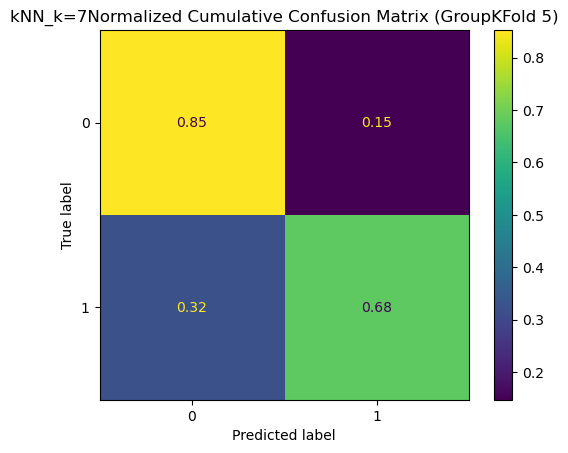

kNN_k=15Cumulative Confusion Matrix
[[30209  4853]
 [ 2884  6054]]
kNN_k=15Normalized Cumulative Confusion Matrix
[[0.86158804 0.13841196]
 [0.32266726 0.67733274]]


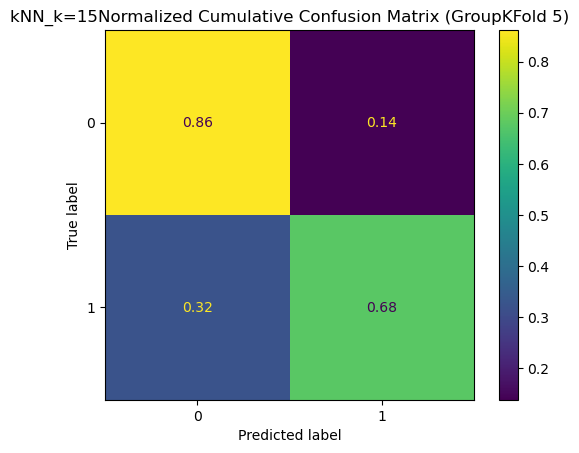

kNN_k=45Cumulative Confusion Matrix
[[31240  3822]
 [ 2708  6230]]
kNN_k=45Normalized Cumulative Confusion Matrix
[[0.8909931  0.1090069 ]
 [0.30297606 0.69702394]]


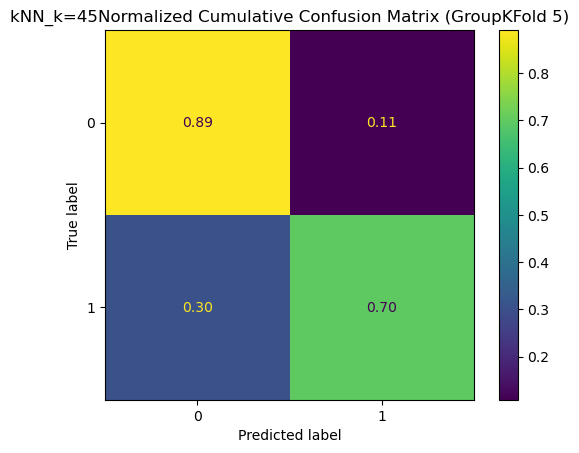

kNN_k=105Cumulative Confusion Matrix
[[32288  2774]
 [ 2906  6032]]
kNN_k=105Normalized Cumulative Confusion Matrix
[[0.92088301 0.07911699]
 [0.32512866 0.67487134]]


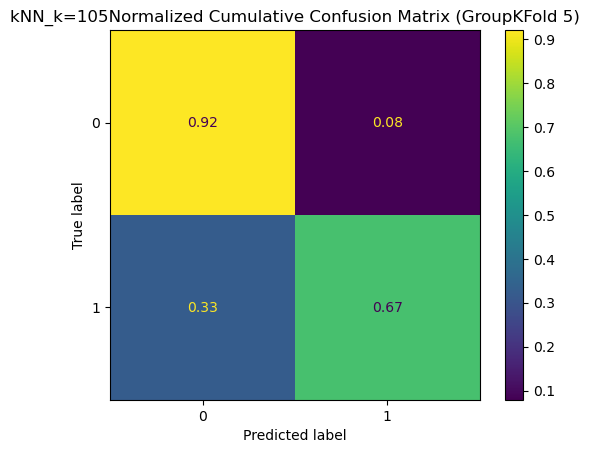

LogRegCumulative Confusion Matrix
[[31537  3525]
 [ 1497  7441]]
LogRegNormalized Cumulative Confusion Matrix
[[0.89946381 0.10053619]
 [0.16748713 0.83251287]]


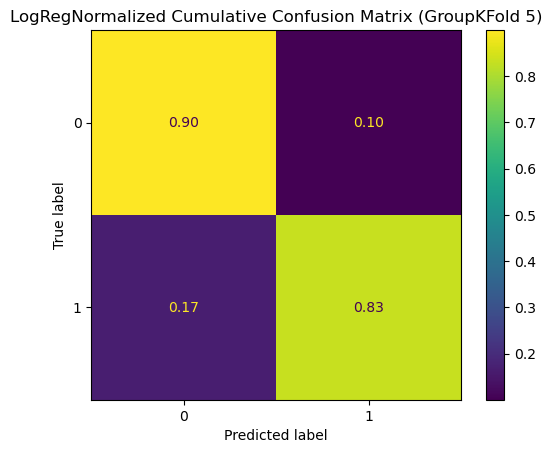

DecisionTreeCumulative Confusion Matrix
[[27373  7689]
 [ 2407  6531]]
DecisionTreeNormalized Cumulative Confusion Matrix
[[0.78070276 0.21929724]
 [0.26929962 0.73070038]]


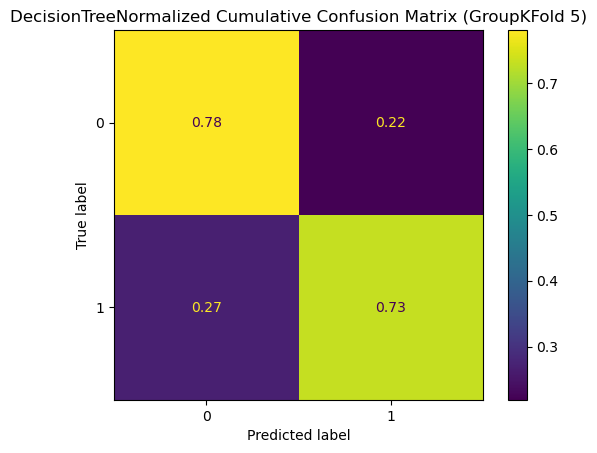

RandomForestCumulative Confusion Matrix
[[29975  5087]
 [ 1280  7658]]
RandomForestNormalized Cumulative Confusion Matrix
[[0.85491415 0.14508585]
 [0.14320877 0.85679123]]


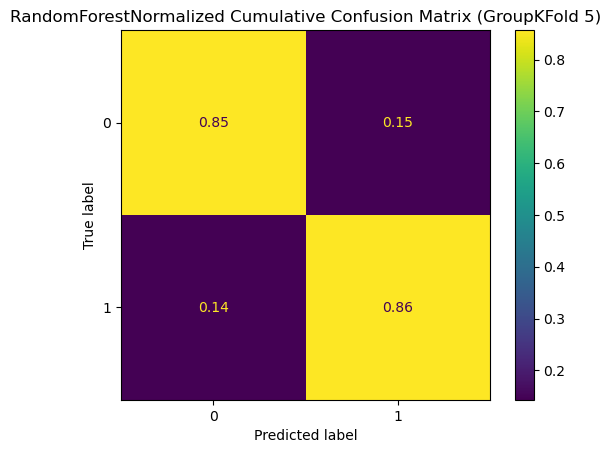

          model  Accuracy_mean  Precision_mean  Recall_mean   F1_mean  \
0        LogReg       0.885317        0.655784     0.829926  0.718638   
1  RandomForest       0.855142        0.569843     0.839467  0.673929   
2     kNN_k=105       0.869167        0.684466     0.642108  0.640463   
3      kNN_k=45       0.850036        0.626196     0.670678  0.623851   
4      kNN_k=15       0.822808        0.551783     0.666002  0.584509   
5       kNN_k=7       0.815258        0.526567     0.668787  0.572461   
6  DecisionTree       0.770228        0.425408     0.710642  0.522550   

   AUROC_mean  
0    0.928752  
1    0.907580  
2    0.865549  
3    0.858886  
4    0.839491  
5    0.826098  
6    0.743452  
==================== N=5 ====================
kNN_k=7Cumulative Confusion Matrix
[[25765  7059]
 [ 2880  8296]]
kNN_k=7Normalized Cumulative Confusion Matrix
[[0.78494394 0.21505606]
 [0.25769506 0.74230494]]


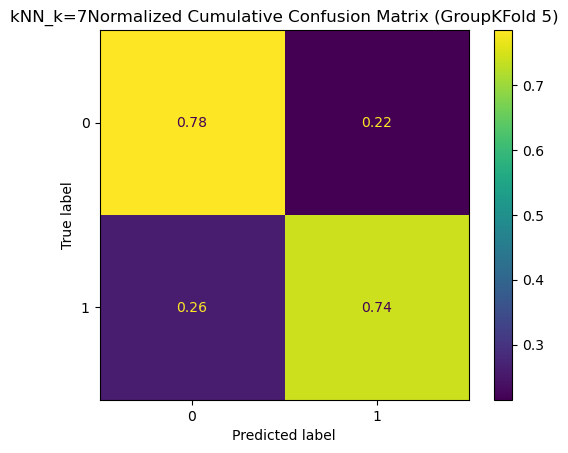

kNN_k=15Cumulative Confusion Matrix
[[26146  6678]
 [ 2891  8285]]
kNN_k=15Normalized Cumulative Confusion Matrix
[[0.7965513  0.2034487 ]
 [0.25867931 0.74132069]]


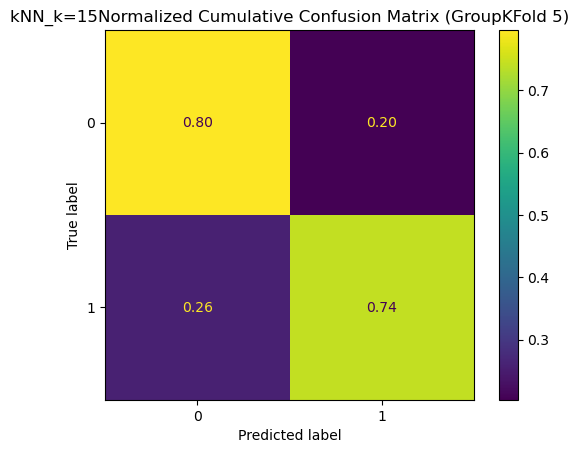

kNN_k=45Cumulative Confusion Matrix
[[26957  5867]
 [ 3053  8123]]
kNN_k=45Normalized Cumulative Confusion Matrix
[[0.82125883 0.17874117]
 [0.27317466 0.72682534]]


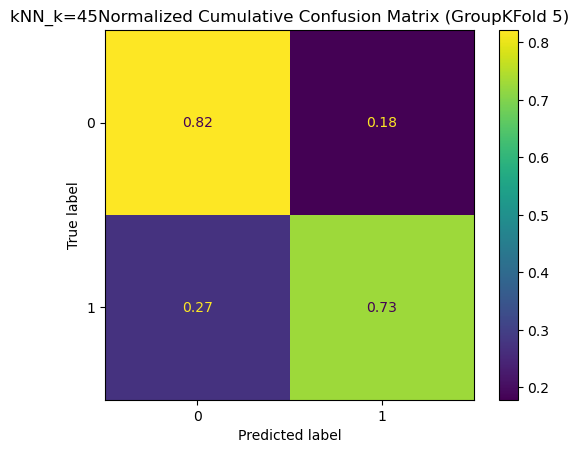

kNN_k=105Cumulative Confusion Matrix
[[27637  5187]
 [ 3161  8015]]
kNN_k=105Normalized Cumulative Confusion Matrix
[[0.84197538 0.15802462]
 [0.28283822 0.71716178]]


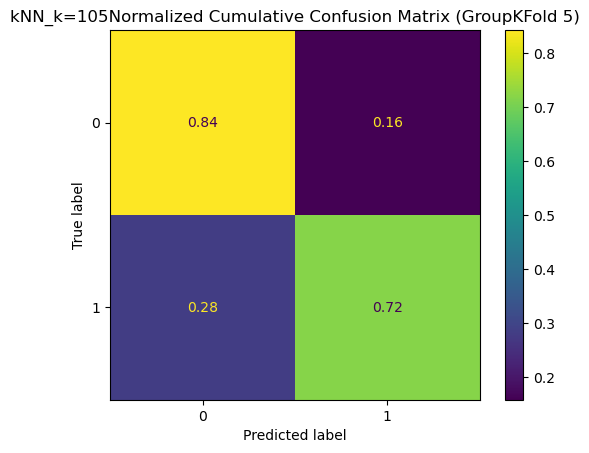

LogRegCumulative Confusion Matrix
[[30415  2409]
 [ 1291  9885]]
LogRegNormalized Cumulative Confusion Matrix
[[0.92660858 0.07339142]
 [0.11551539 0.88448461]]


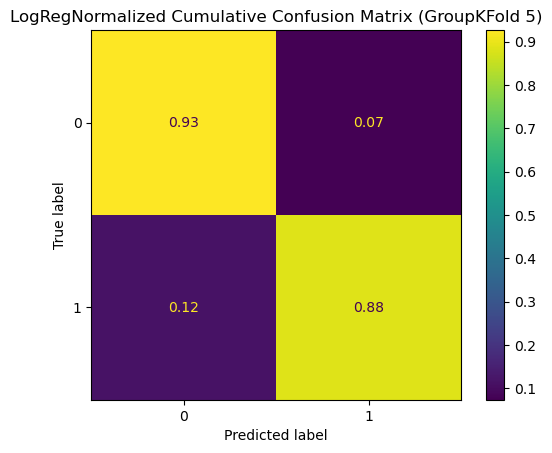

DecisionTreeCumulative Confusion Matrix
[[26521  6303]
 [ 2734  8442]]
DecisionTreeNormalized Cumulative Confusion Matrix
[[0.80797587 0.19202413]
 [0.24463135 0.75536865]]


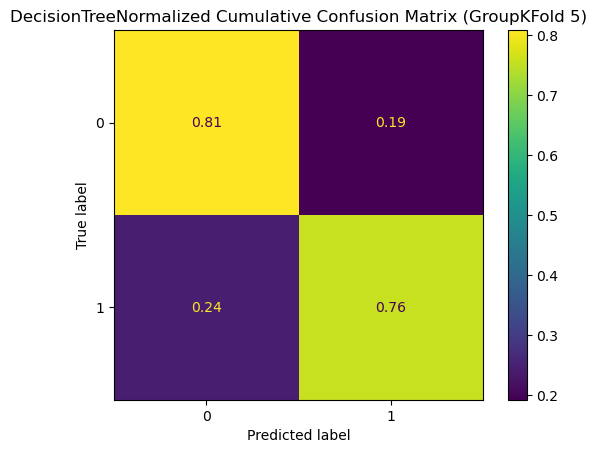

RandomForestCumulative Confusion Matrix
[[27663  5161]
 [ 1111 10065]]
RandomForestNormalized Cumulative Confusion Matrix
[[0.84276749 0.15723251]
 [0.09940945 0.90059055]]


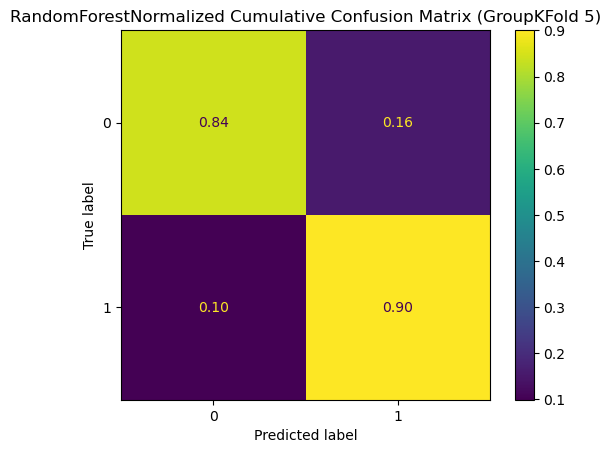

          model  Accuracy_mean  Precision_mean  Recall_mean   F1_mean  \
0        LogReg       0.914364        0.785820     0.864527  0.818900   
1  RandomForest       0.856564        0.624855     0.877401  0.727330   
2  DecisionTree       0.795003        0.547946     0.738663  0.622790   
3     kNN_k=105       0.809061        0.561480     0.674960  0.607692   
4      kNN_k=45       0.795981        0.539409     0.692794  0.600585   
5      kNN_k=15       0.781061        0.516718     0.715040  0.592514   
6       kNN_k=7       0.772894        0.507353     0.723557  0.586520   

   AUROC_mean  
0    0.947769  
1    0.928623  
2    0.772090  
3    0.856272  
4    0.842383  
5    0.825538  
6    0.810764  
==================== N=7 ====================
kNN_k=7Cumulative Confusion Matrix
[[23154  8138]
 [ 3075  9633]]
kNN_k=7Normalized Cumulative Confusion Matrix
[[0.73993353 0.26006647]
 [0.24197356 0.75802644]]


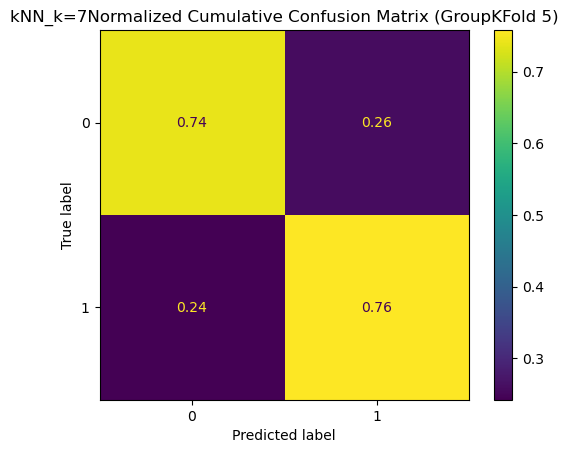

kNN_k=15Cumulative Confusion Matrix
[[23828  7464]
 [ 3057  9651]]
kNN_k=15Normalized Cumulative Confusion Matrix
[[0.76147258 0.23852742]
 [0.24055713 0.75944287]]


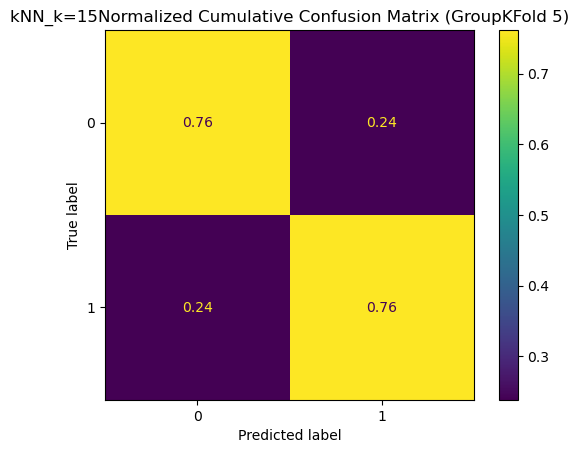

kNN_k=45Cumulative Confusion Matrix
[[24693  6599]
 [ 3209  9499]]
kNN_k=45Normalized Cumulative Confusion Matrix
[[0.78911543 0.21088457]
 [0.2525181  0.7474819 ]]


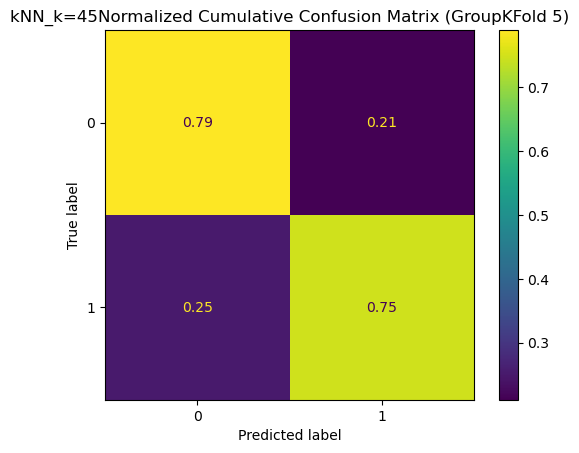

kNN_k=105Cumulative Confusion Matrix
[[25307  5985]
 [ 3342  9366]]
kNN_k=105Normalized Cumulative Confusion Matrix
[[0.80873706 0.19126294]
 [0.26298395 0.73701605]]


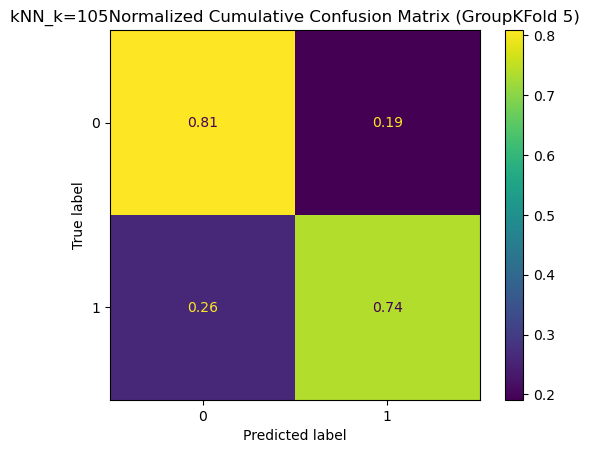

LogRegCumulative Confusion Matrix
[[28952  2340]
 [ 1395 11313]]
LogRegNormalized Cumulative Confusion Matrix
[[0.9252205  0.0747795 ]
 [0.10977337 0.89022663]]


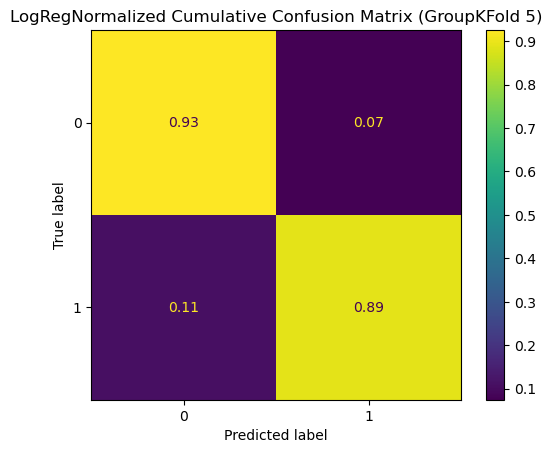

DecisionTreeCumulative Confusion Matrix
[[22291  9001]
 [ 3312  9396]]
DecisionTreeNormalized Cumulative Confusion Matrix
[[0.7123546  0.2876454 ]
 [0.26062323 0.73937677]]


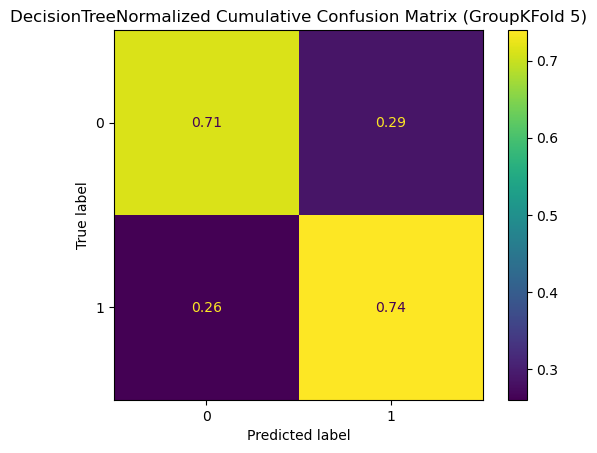

RandomForestCumulative Confusion Matrix
[[25988  5304]
 [ 1018 11690]]
RandomForestNormalized Cumulative Confusion Matrix
[[0.83049981 0.16950019]
 [0.08010702 0.91989298]]


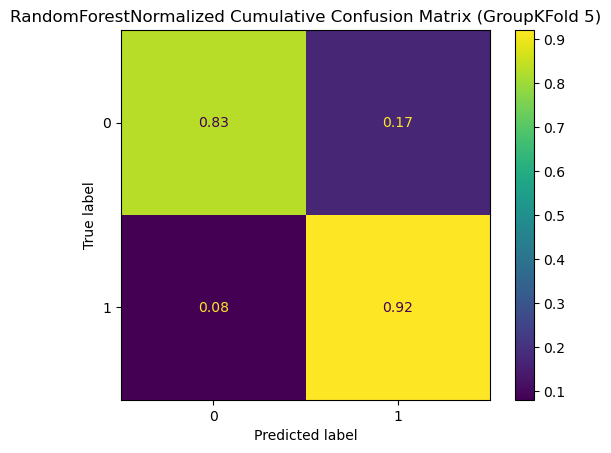

          model  Accuracy_mean  Precision_mean  Recall_mean   F1_mean  \
0        LogReg       0.913225        0.813727     0.858226  0.832745   
1  RandomForest       0.855564        0.657363     0.898325  0.757380   
2     kNN_k=105       0.786883        0.561371     0.691345  0.617546   
3      kNN_k=45       0.775919        0.547384     0.708139  0.614760   
4      kNN_k=15       0.759564        0.528972     0.730987  0.609518   
5       kNN_k=7       0.743675        0.511177     0.735131  0.596802   
6  DecisionTree       0.721083        0.488406     0.735706  0.577665   

   AUROC_mean  
0    0.953746  
1    0.932847  
2    0.838718  
3    0.823004  
4    0.805794  
5    0.791221  
6    0.723005  


In [21]:
for label, df_N in dfs:
    print('==================== ' + str(label) + ' ====================')

    models = {}

    #k-NN
    for k in [7, 15, 45, 105]:
        models['kNN_k=' + str(k)] = Pipeline([('imputer', SimpleImputer(strategy = 'median')), ('scaler', StandardScaler()), 
            ('clf', KNeighborsClassifier(n_neighbors = k, weights ='distance', metric = 'minkowski'))])

    # Logistic Regression
    models['LogReg'] = Pipeline([('imputer', SimpleImputer(strategy = 'median')), ('scaler', StandardScaler()),
        ('clf', LogisticRegression(penalty = 'l2', solver = 'liblinear', class_weight = 'balanced', max_iter = 1000))])

    # Decision Tree
    models['DecisionTree'] = Pipeline([('imputer', SimpleImputer(strategy = 'median')),
        ('clf', DecisionTreeClassifier(class_weight='balanced'))])

    # Random Forest
    models['RandomForest'] = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
        ('clf', RandomForestClassifier(n_estimators = 300, max_depth = 10, min_samples_leaf = 10, class_weight = 'balanced_subsample',))])

    #Group k fold evaluation (5 splits)
    results = evaluate_models_groupkfold(df_N, models, n_splits = 5)

    print(results[['model', 'Accuracy_mean', 'Precision_mean', 'Recall_mean', 'F1_mean',  'AUROC_mean']])